In [31]:
import cell2fate as c2f
import scanpy as sc
import numpy as np

In [32]:
savings_directory = '/nfs/team283/aa16/data/cell2fate/trained_models/'

# Parameter settings for this run:
max_epochs = 1000
learning_rate = 0.01
batch_size = None
posterior_samples = 5

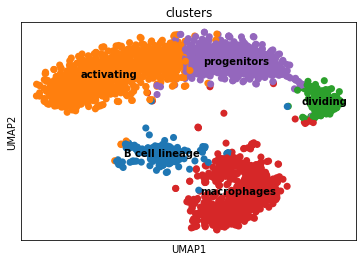

In [37]:
adata = sc.read_h5ad('/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/MouseBoneMarrow/MouseBoneMarrow_anndata.h5ad')
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data')

We register the anndata object and create the model instance as with other scvi-tools methods.

Keeping at most 100000 cells per cluster
Filtered out 19382 genes that are detected 3 counts (shared).
Extracted 2000 highly variable genes.


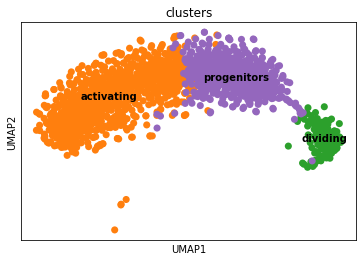

In [38]:
remove_clusters = ['B cell lineage', 'macrophages']
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = remove_clusters,
                                min_shared_counts = 3, n_var_genes= 2000)
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data')

In [39]:
adata

AnnData object with n_obs × n_vars = 1645 × 2000
    obs: 'cluster', 'cell_type', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

Initialize the model:

In [6]:
n_modules = 6

In [7]:
c2f.Cell2fate_ModularTranscriptionRate_model_SingleLineage_GlobalTime.setup_anndata(adata,
                                                                                    spliced_label='spliced',
                                                                                    unspliced_label='unspliced')

In [8]:
mod = c2f.Cell2fate_ModularTranscriptionRate_model_SingleLineage_GlobalTime(adata,
                                                        stochastic_v_ag_hyp_prior={"alpha": 3.0, "beta": 3.0},
                                                        detection_hyp_prior={"alpha": 10.0, "mean_alpha": 1.0, "mean_beta": 1.0},
                                                        Tmax_prior={"mean": 50, "sd": 50},
                                                       n_modules = n_modules)

In [9]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2fate_ModularTranscriptionRate_model_SingleLineage_GlobalTime.setup_anndata` 
with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced',
│   'cluster_label': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 1645  │
│      n_vars      │ 1697  │
│     n_batch      │   1   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

The lower the learning rate and the higher the number of iterations, the better the results. For example a learning rate of 0.001 and 100000 iterations will give slightly better results than here and a learning rate 0.1 and just 100 iterations will give slightly worse results, but has the upside of a very short training time.

In [10]:
mod.train(use_gpu=True, batch_size = batch_size, max_epochs = max_epochs, lr = learning_rate)
# mod.train(use_gpu=True, batch_size = batch_size, max_epochs = 1, lr = 10**(-10)) # (For checking initial values)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.53it/s, v_num=1, elbo_train=2.17e+6]


We plot training history over multiple windows to effectively assess convergence (which is not reached here but it is close.)

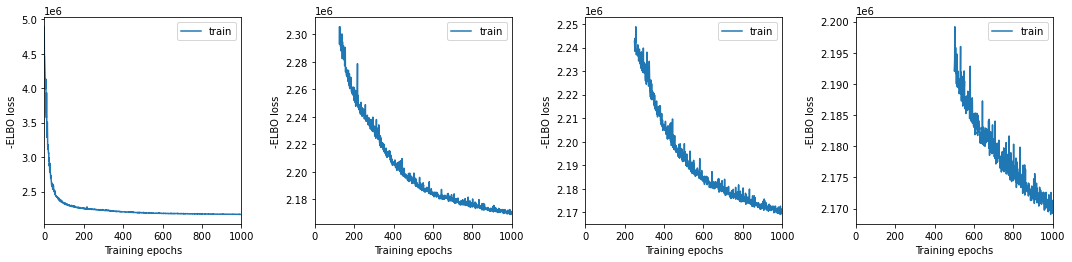

In [11]:
mod.max_epochs = max_epochs
mod.view_history()

Here we export the model posterior to the anndata object and calculate some useful quantities like RNAvelocity based on it.

In [12]:
adata = mod.export_posterior(adata,
                 sample_kwargs = {"num_samples": posterior_samples, "batch_size" : adata.n_obs,
                                  "use_gpu" : True, 'return_samples': True},
                 full_velocity_posterior = True)

Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.97it/s]


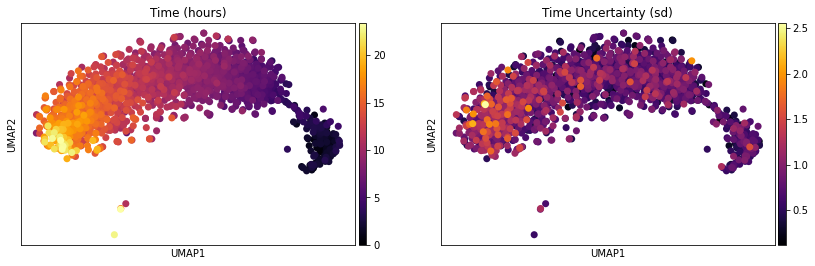

In [13]:
sc.pl.umap(adata, color = ['Time (hours)', 'Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2)

T_mON [[[ 0.         3.2743268  6.3676033  9.472406  13.485326  22.48134  ]]]
T_mOFF [[[ 3.939862  8.589208 12.610405 20.142347 28.154194 29.1784  ]]]
Tmax 17.568945


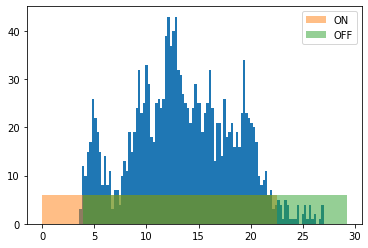

In [14]:
import matplotlib.pyplot as plt
plt.hist(mod.samples['post_sample_means']['T_c'].flatten(), bins = 100)
plt.hist(mod.samples['post_sample_means']['T_mON'].flatten(), bins = 1, alpha = 0.5, label = 'ON')
plt.hist(mod.samples['post_sample_means']['T_mOFF'].flatten(), bins = 1, alpha = 0.5, label = 'OFF')
plt.legend()
print('T_mON', mod.samples['post_sample_means']['T_mON'])
print('T_mOFF', mod.samples['post_sample_means']['T_mOFF'])
print('Tmax', mod.samples['post_sample_means']['Tmax'])

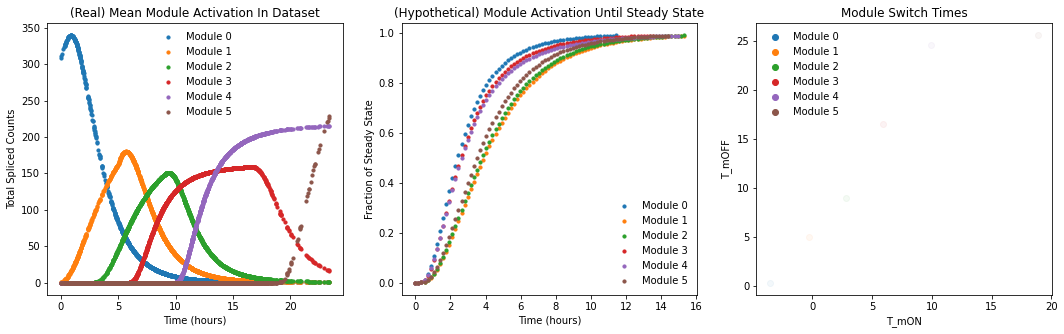

In [15]:
mod.compare_module_activation(adata, chosen_modules = [range(n_modules)], max_time_steps = 200, interval = 0.01)

In [16]:
# adata.obs['spliced_log10_total'] = np.log10(np.sum(adata.layers['spliced'], axis = 1))
# adata.obs['unspliced_log10_total'] = np.log10(np.sum(adata.layers['unspliced'], axis = 1))
# adata.obs['spliced_total'] = np.sum(adata.layers['spliced'], axis = 1)
# adata.obs['unspliced_total'] = np.sum(adata.layers['unspliced'], axis = 1)
# adata.obs['unspliced_spliced_ratio'] = np.sum(adata.layers['unspliced'], axis = 1)/np.sum(adata.layers['spliced'], axis = 1)
# sc.pl.umap(adata, color = ['spliced_log10_total', 'unspliced_log10_total',
#                            'spliced_total', 'unspliced_total',
#                            'unspliced_spliced_ratio'],
#            legend_loc = 'right margin', size = 200, color_map = 'inferno', ncols = 2)

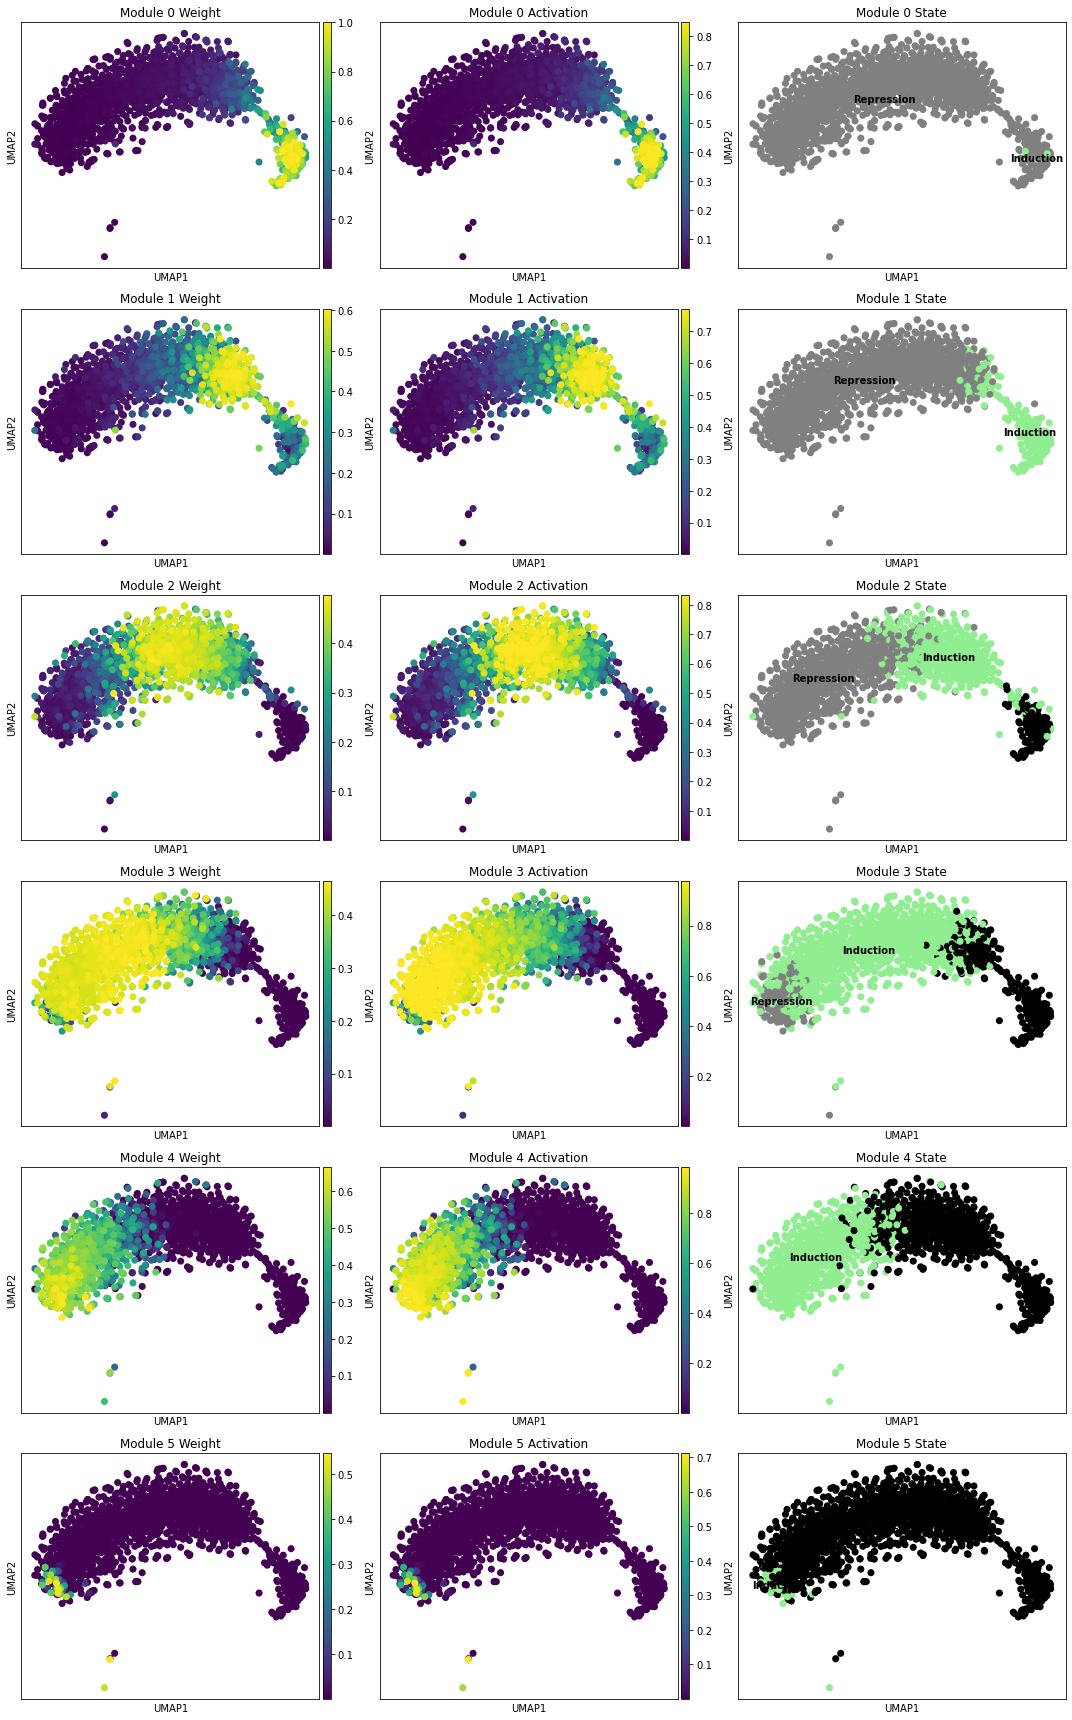

In [17]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata)

In [18]:
# for i in range(n_modules):
#     adata.obs['Module Weight']

(array([1240.,  149.,   49.,   17.,   15.,   16.,   20.,   24.,   38.,
          77.]),
 array([6.4234837e-04, 8.5194506e-02, 1.6974667e-01, 2.5429884e-01,
        3.3885098e-01, 4.2340314e-01, 5.0795531e-01, 5.9250748e-01,
        6.7705959e-01, 7.6161176e-01, 8.4616393e-01], dtype=float32),
 <BarContainer object of 10 artists>)

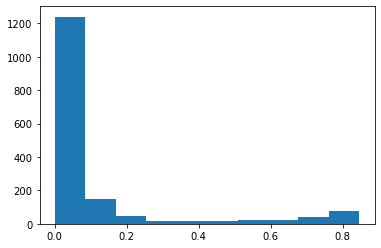

In [19]:
plt.hist(adata.obs['Module 0 Activation'])

Computing velocity produced by Module 0 ...
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity embedding
    finished (0:00:00) --> added
    'Module 0 Velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity produced by Module 1 ...
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity embedding
    finished (0:00:00) --> added
    'Module 1 Velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity produced by Module 2 ...
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity embedding
    finished (0:00:00) --> added
    'Module 2 Velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity produced by Module 3 ...
computing neighbors
    finished

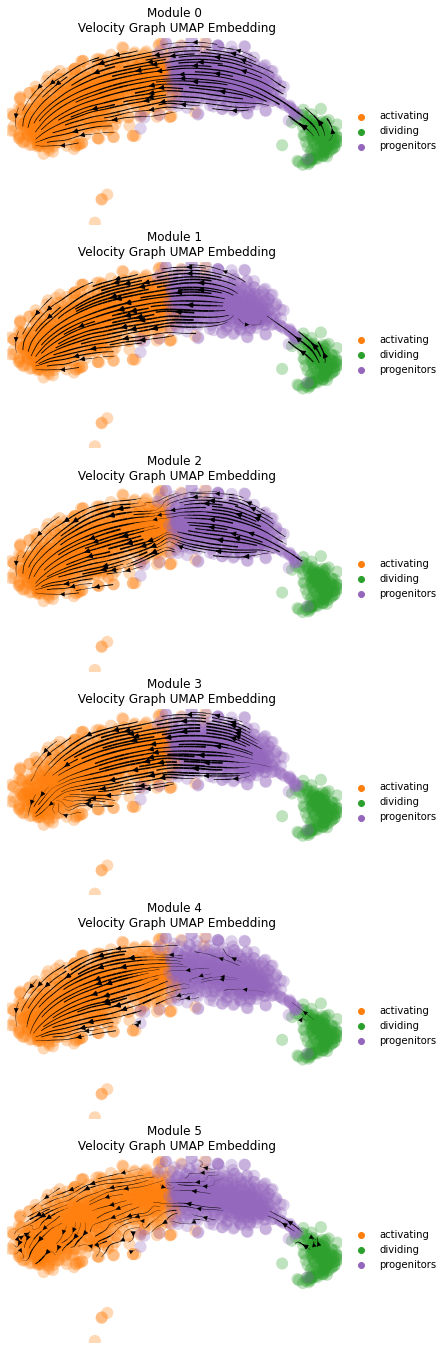

In [20]:
mod.compute_and_plot_module_velocity(adata)

Computing total RNAvelocity ...


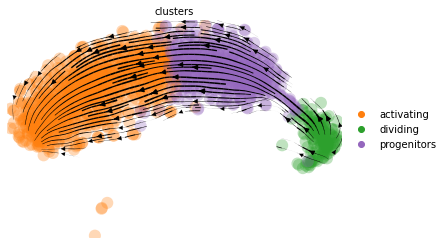

In [21]:
mod.compute_and_plot_total_velocity(adata)

(array([470., 628., 315., 147.,  43.,  30.,   6.,   4.,   1.,   1.]),
 array([ 622. ,  938.4, 1254.8, 1571.2, 1887.6, 2204. , 2520.4, 2836.8,
        3153.2, 3469.6, 3786. ], dtype=float32),
 <BarContainer object of 10 artists>)

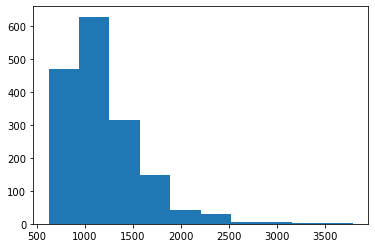

In [22]:
import matplotlib.pyplot as plt
plt.hist(np.sum(adata.layers['spliced'], axis = 1))

(array([147.,  88., 237., 320., 263., 218., 211., 112.,  30.,  19.]),
 array([ 0.       ,  2.3397288,  4.6794577,  7.019186 ,  9.358915 ,
        11.698644 , 14.038372 , 16.378101 , 18.71783  , 21.057558 ,
        23.397287 ], dtype=float32),
 <BarContainer object of 10 artists>)

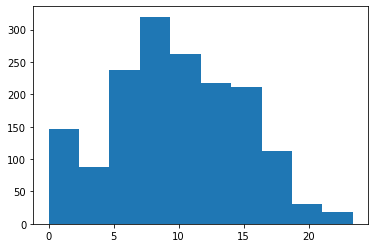

In [23]:
plt.hist(mod.samples['post_sample_means']['T_c'].flatten() - np.min(mod.samples['post_sample_means']['T_c'].flatten()))

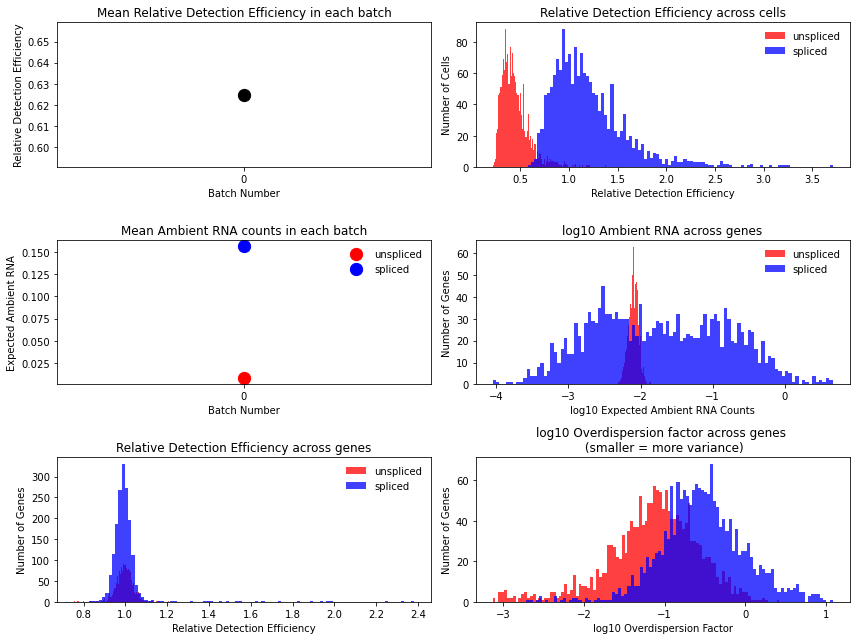

In [24]:
mod.plot_technical_variables(adata)

In [25]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

A_mgON mean: 0.13151725
gamma_g mean: 1.1075212
beta_g mean: 1.2607765
lam_mi, all modules: 
 
 [[[1.93 0.84]]

 [[0.5  0.93]]

 [[0.55 1.43]]

 [[1.89 0.88]]

 [[2.19 1.69]]

 [[0.66 0.85]]]


In [26]:
tab = mod.get_module_top_features(adata, p_adj_cutoff=0.1)
tab

,Module Number,Genes Ranked,TFs Ranked,Terms Ranked
0,0,"Top2a, Rrm2, Dbf4, Mki67, Cdca8, Ncapd2, Racga...","E2f8, Ctcf, Tshz1, Smarca5, Sp1, Pbrm1, Arid1a...",mitotic sister chromatid segregation (GO:00000...
1,1,"Ptpn1, Mgst2, Ubr2, Zmpste24, Manea, Prdx5, Ac...","Tet3, Erg, Fli1, Zscan29, Vezf1, Fubp1, Ncoa4,...","neutrophil degranulation (GO:0043312), neutrop..."
2,2,"1810006J02Rik, Ldhc, Fbxl17, Slc25a24, Pirb, S...","Tcf4, Dach1, Erg, Arid5b, Ikzf1, Ncoa4, Arid2,...","neutrophil degranulation (GO:0043312), neutrop..."
3,3,"Mrgpra2a, Ceacam10, Acvrl1, Rin2, Trf, Prkcd, ...","Rara, Max, Sp140, Zfp608, Zfp516, Kdm5b, Thap6...","neutrophil degranulation (GO:0043312), neutrop..."
4,4,"Gm5483, Il1b, Pla2g7, Tnfrsf1a, Cd101, Nlrp3, ...","Trps1, Fosl2, Jdp2, Bcl6, Zfp106, Plek, Nr4a3,...",cytokine-mediated signaling pathway (GO:001922...
5,5,"LOC100038947, Sirpb1b, Bach2, Kif18a, Bbx, Stf...","Bach2, Bbx, Thap6, Terf1, Purg, Jdp2, Nr4a3, S...","regulation of defense response (GO:0031347), p..."


In [27]:
tab['Terms Ranked'].iloc[2]

'neutrophil degranulation (GO:0043312), neutrophil activation involved in immune response (GO:0002283), neutrophil mediated immunity (GO:0002446), phosphorylation (GO:0016310), regulation of metal ion transport (GO:0010959), regulation of smooth muscle cell migration (GO:0014910), positive regulation of response to external stimulus (GO:0032103), secretory granule membrane (GO:0030667), tertiary granule (GO:0070820), focal adhesion (GO:0005925), cell-substrate junction (GO:0030055), chromaffin granule (GO:0042583), vesicle (GO:0031982), actin cytoskeleton (GO:0015629), intracellular vesicle (GO:0097708), bounding membrane of organelle (GO:0098588), cortical actin cytoskeleton (GO:0030864), specific granule membrane (GO:0035579), mRNA cleavage and polyadenylation specificity factor complex (GO:0005847), azurophil granule (GO:0042582), specific granule (GO:0042581), tertiary granule lumen (GO:1904724), cortical cytoskeleton (GO:0030863), lysosomal membrane (GO:0005765), endocytic vesicle

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


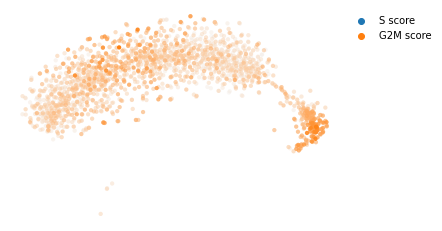

In [28]:
import scvelo as scv
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

This is how we can save the model and anndata object for later use:

In [29]:
save = False
if save:
    # Make an interpretable name for this run:
    run_name = savings_directory + 'PancreasData' + '+Genes_' + str(len(adata.var_names)) + \
    '+Cells_' + str(len(adata.obs_names)) +  \
    '+Model_Cell2fate_ModularTranscriptionRate_NoSplicing_2' + '+Modules_' + str(max_modules) \
    + '+Lineages_' + str(max_lineages) + '+TrainingEpochs_' + str(max_epochs) \
    + '+LearningRate_' + str(learning_rate) + '+BatchSize_' + str(batch_size) + '+PosteriorSamples_' + str(posterior_samples)
    adata_file = run_name + "/anndata.h5ad"
    # Save model:
    mod.save(f"{run_name}", overwrite=True)
    # Save adata object:
    adata.write(adata_file)

This is how we can load the model again:

In [30]:
# adata = sc.read_h5ad(adata_file)
# mod = c2f.Cell2fate_ModularTranscriptionRate_FixedModules.load(f"{run_name}", adata)